In [ ]:
#-------------------------------------------------------------------------------

In [ ]:
# prompt: how gaussian  distribution will help me in above code?

# 3. Uncertainty Estimation:
#    - When dealing with the segmentation masks generated by SAM, you could use a Gaussian distribution
#      to model uncertainty about the mask boundaries. For instance, instead of just a hard binary mask,
#      you could obtain a soft mask with probabilities of belonging to the foreground class at each pixel,
#      represented by a Gaussian distribution centered around the predicted mask boundary.


# You can integrate this into your preprocessing pipeline before feeding data to the model.

# Note: The above example is a simple illustration. The specifics of how to use a Gaussian distribution
# in your code will depend on the exact problem you are trying to solve and the dataset you have.


# You can explore Gaussian distributions in more detail with:
# - Gaussian Mixture Models (GMMs): If there are multiple objects in your image or if the foreground is complex,
#   a GMM could be a good choice to model the different distributions present in your data.
# - Gaussian Processes: If you want to model the probability distribution over functions, you could look
#   into Gaussian Processes.



In [1]:
!pip install segment-anything-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.4 MB/s eta 0:00:00


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-09-29 03:47:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.128, 18.164.78.121, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  78.1MB/s    in 25s     

2024-09-29 03:47:49 (96.5 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
from segment_anything import sam_model_registry, SamPredictor
from scipy.stats import norm



def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))



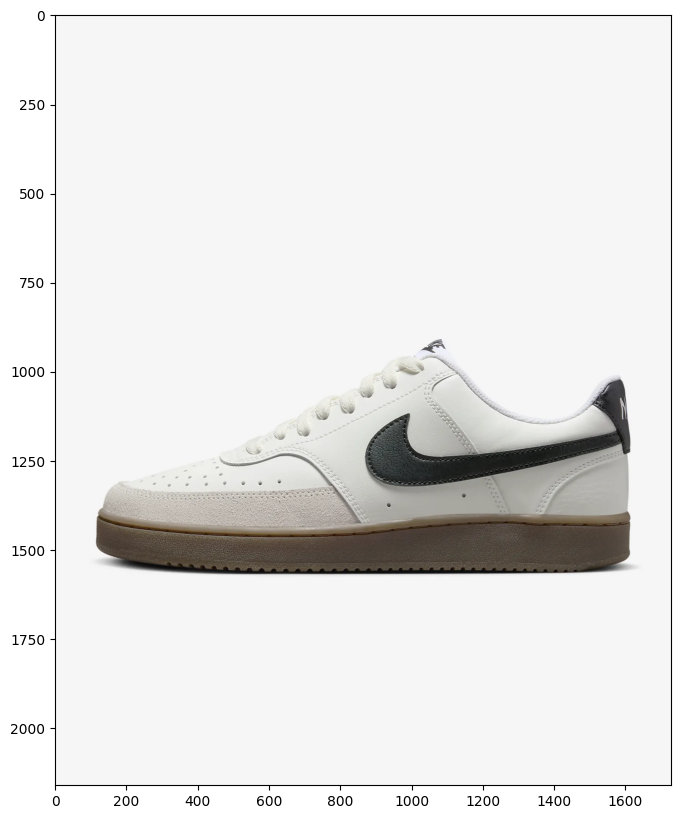

In [4]:
image = cv2.imread('/content/nike1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


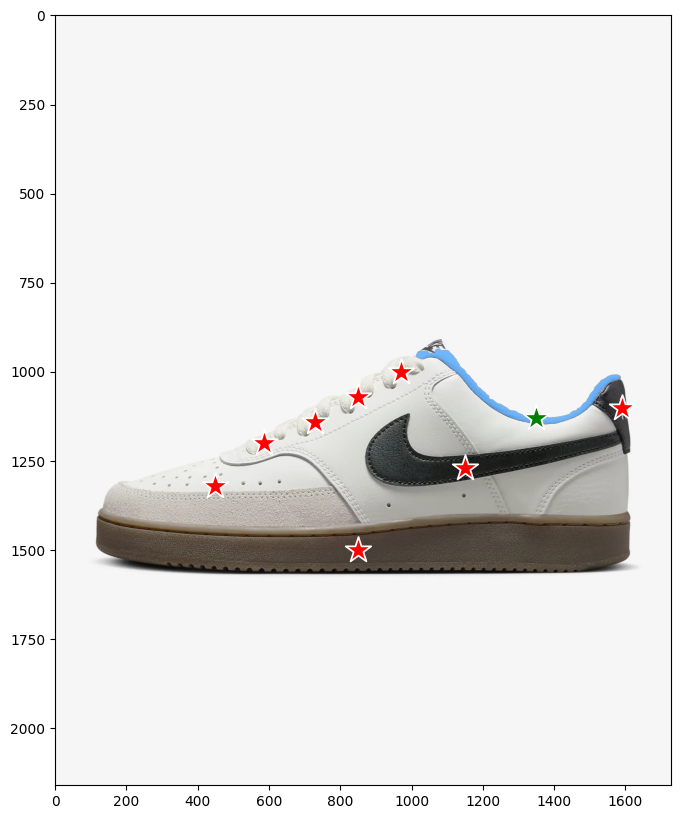

In [6]:
input_point = np.array([[450,1320], [850, 1500], [1150,1270], [1590,1100], [585,1200],
                        [730,1140] , [850, 1070], [970, 1000], [1350,1130]])
input_label = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1]) # Added a label for the third point


# Predict masks and scores
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

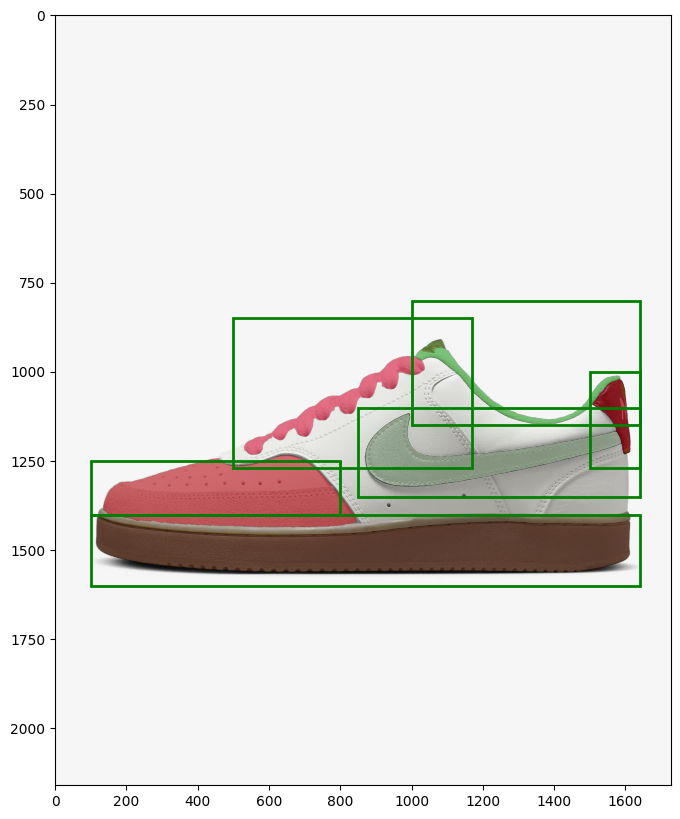

In [7]:
input_boxes = torch.tensor([

        [100, 1250, 800, 1400],
        [100, 1400, 1640, 1600],
        [850, 1100, 1640, 1350],
        [500, 850, 1170, 1270],
        [1000, 800, 1640, 1150],
        [1500, 1000,1640, 1270]

], device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('on')
plt.show()

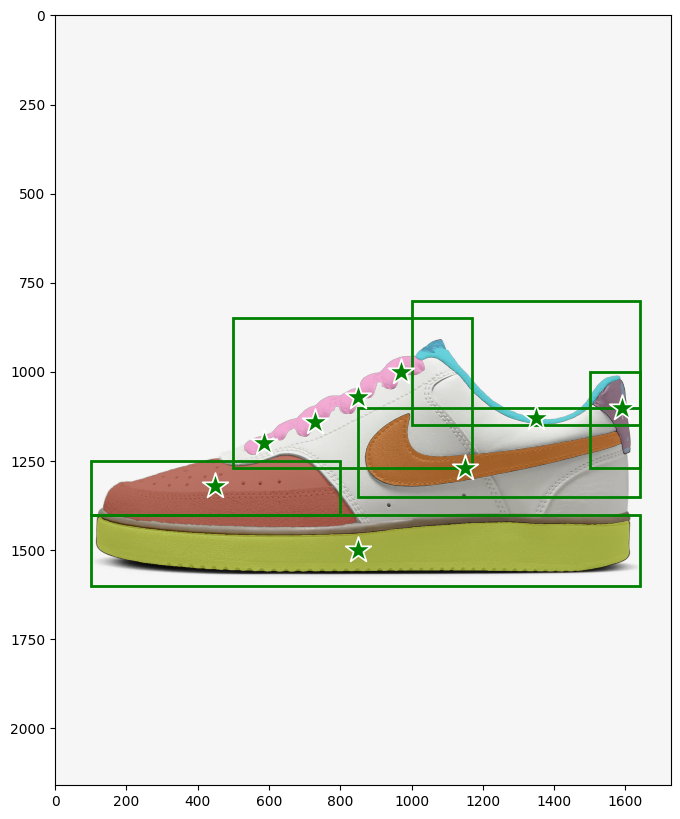

In [8]:

# ---------------------------------------------------------------------- Main script below
input_point = np.array([[450,1320], [850, 1500], [1150,1270], [1590,1100], [585,1200],
                        [730,1140] , [850, 1070], [970, 1000], [1350,1130]])
input_label = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1]) # Added a label for the third point

input_boxes = torch.tensor([
    [100, 1250, 800, 1400],
    [100, 1400, 1640, 1600],
    [850, 1100, 1640, 1350],
    [500, 850, 1170, 1270],
    [1000, 800, 1640,1150],
    [1500, 1000,1640, 1270]
], device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()


In [9]:
# prompt: implement above for my code

def remove_background(image, mask):
  """Removes the background from an image using a mask.

  Args:
    image: The original image as a NumPy array.
    mask: The mask generated by SAM as a NumPy array.

  Returns:
    The image with the background removed.
  """

  # Create a blank image with the same size as the original
  result_image = np.zeros_like(image)

  # Ensure the mask has the correct number of dimensions
  if len(mask.shape) == 3:
    mask = mask.squeeze(0)
  if len(mask.shape) == 4:
    mask = mask.squeeze(0).squeeze(0)

  # Apply the mask to the original image
  result_image[mask] = image[mask]

  return result_image


# Example of how to use a Gaussian distribution for input normalization (illustrative)
def normalize_features(features):
  """Normalizes input features using Gaussian distribution.

  Args:
    features: A NumPy array of features.

  Returns:
    The normalized features.
  """

  means = np.mean(features, axis=0)
  stds = np.std(features, axis=0)
  normalized_features = (features - means) / stds
  return normalized_features


# ... (rest of your code) ...


# Assume you have 'feature_array' with your extracted features
# feature_array = ...  # Replace with your actual features

# Normalize the features
# normalized_features = normalize_features(feature_array)

# You can now use 'normalized_features' as your input to the model or further process it.



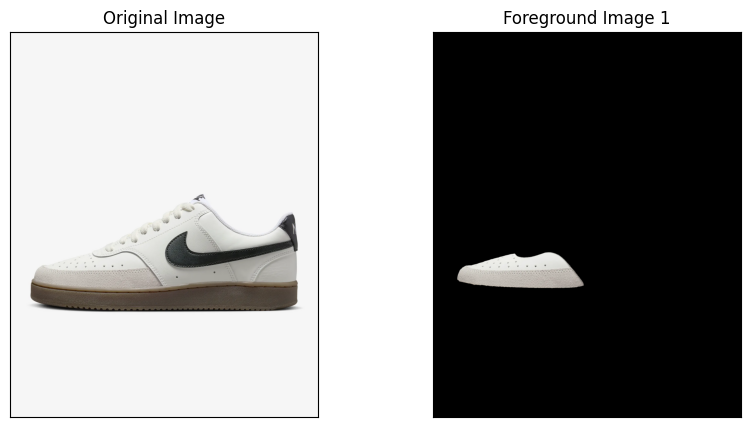

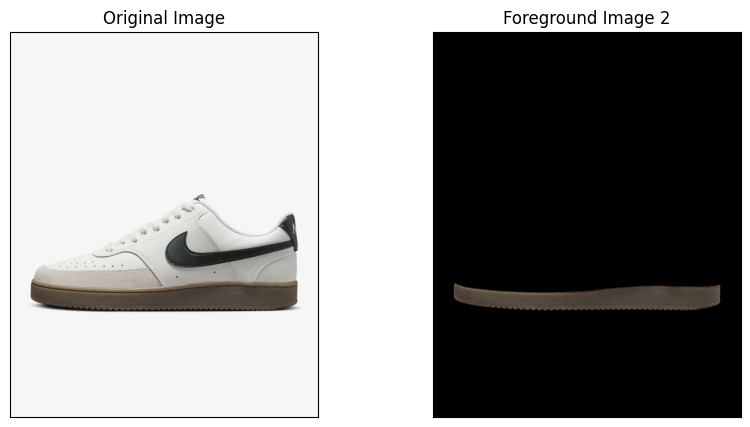

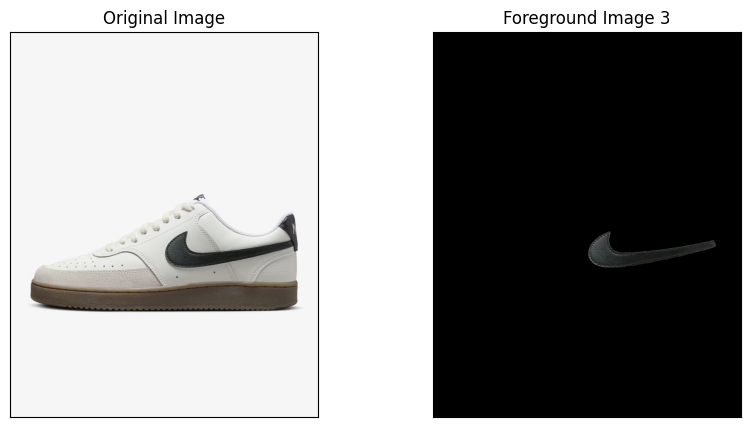

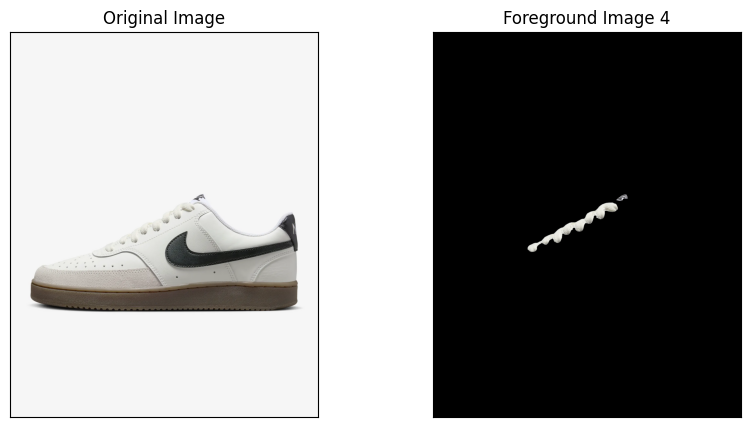

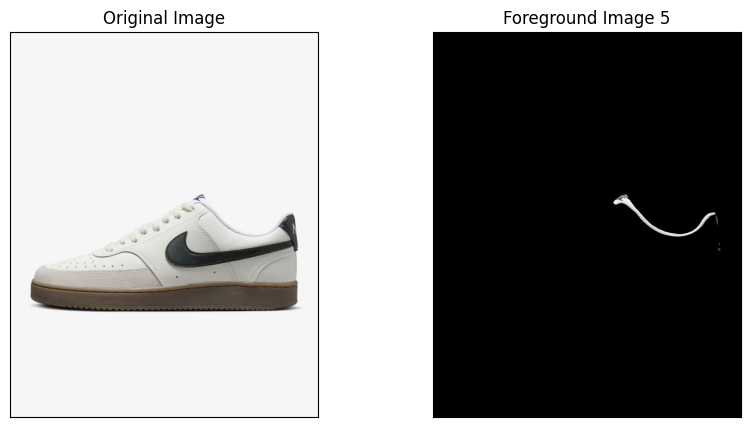

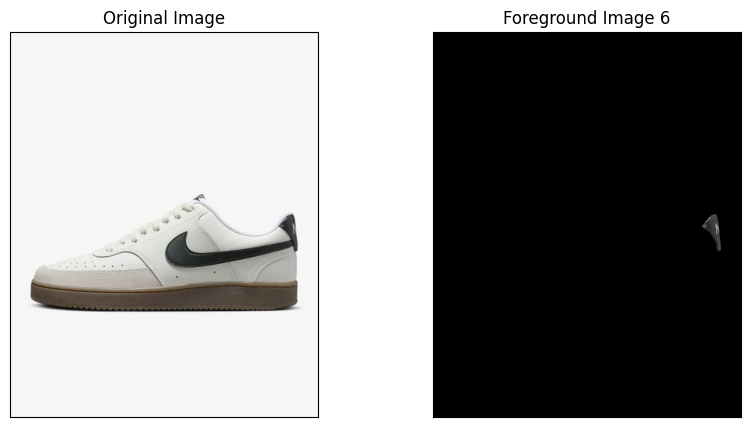

In [10]:
if 'masks' in locals():
  for i, mask in enumerate(masks):
    foreground_image = remove_background(image, mask.cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(image)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(foreground_image)
    plt.title(f'Foreground Image {i+1}'), plt.xticks([]), plt.yticks([])
    plt.show()
else:
  print("Masks variable not found. Please run the SAM prediction code first.")


In [16]:
# prompt: using above code i want to make a folder which classifies Foreground Image annote it with this list [front,soul_part,logo,less,upper_less,back_logo]

import os
import shutil

# Create a directory for classified foreground images
if not os.path.exists('classified_foreground_images'):
  os.makedirs('classified_foreground_images')

# Assuming you have a list of labels corresponding to each mask
labels = ['front', 'soul_part', 'logo', 'less', 'upper_less', 'back_logo']

if 'masks' in locals():
  for i, mask in enumerate(masks):
    foreground_image = remove_background(image, mask.cpu().numpy())

    # Assign a label to the foreground image (you'll need to define how you want to do this)
    # For this example, let's assign labels sequentially from the list
    label = labels[i % len(labels)]

    # Create a subdirectory for the label if it doesn't exist
    label_dir = os.path.join('classified_foreground_images', label)
    if not os.path.exists(label_dir):
      os.makedirs(label_dir)

    # Save the foreground image to the corresponding label subdirectory
    image_filename = f'foreground_image_{i + 1}.png'
    image_path = os.path.join(label_dir, image_filename)
    plt.imsave(image_path, foreground_image)

    print(f'Saved foreground image {i + 1} with label "{label}" to {image_path}')
else:
  print("Masks variable not found. Please run the SAM prediction code first.")


Saved foreground image 1 with label "front" to classified_foreground_images/front/foreground_image_1.png
Saved foreground image 2 with label "soul_part" to classified_foreground_images/soul_part/foreground_image_2.png
Saved foreground image 3 with label "logo" to classified_foreground_images/logo/foreground_image_3.png
Saved foreground image 4 with label "less" to classified_foreground_images/less/foreground_image_4.png
Saved foreground image 5 with label "upper_less" to classified_foreground_images/upper_less/foreground_image_5.png
Saved foreground image 6 with label "back_logo" to classified_foreground_images/back_logo/foreground_image_6.png
